In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load dataset
train_data = pd.read_csv('DataTrain.csv')
print(train_data.head())


   engine_id  cycle   set1    set2    set3  sensor_val1  sensor_val2  \
0          1      1  100.0 -0.0007 -0.0004      9046.19       521.66   
1          1      2  100.0  0.0019 -0.0003      9044.07       522.28   
2          1      3  100.0 -0.0043  0.0003      9052.94       522.42   
3          1      4  100.0  0.0007  0.0000      9049.48       522.86   
4          1      5  100.0 -0.0019 -0.0002      9055.15       522.19   

   sensor_val3  sensor_val4  sensor_val5  ...  sensor_val12  sensor_val13  \
0      8138.62      1589.70       554.36  ...           392       2388.06   
1      8131.49      1591.82       553.75  ...           392       2388.04   
2      8133.23      1587.99       554.26  ...           390       2388.08   
3      8133.83      1582.79       554.45  ...           392       2388.11   
4      8133.80      1582.85       554.00  ...           393       2388.06   

   sensor_val14  sensor_val15  sensor_val16  sensor_val17  sensor_val18  \
0           1.3        641.82

In [3]:

def compute_engine_rul(df):
    """Calculate Remaining Useful Life for each engine unit"""
    df = df.copy()
    # Directly add max cycle using transform
    df['max_cycle'] = df.groupby('engine_id')['cycle'].transform('max')
    df['RUL'] = df['max_cycle'] - df['cycle']
    return df

# Process RUL calculation
rul_data = compute_engine_rul(train_data)


In [4]:
numerical_columns = rul_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Numerical columns:", numerical_columns)

Numerical columns: ['engine_id', 'cycle', 'set1', 'set2', 'set3', 'sensor_val1', 'sensor_val2', 'sensor_val3', 'sensor_val4', 'sensor_val5', 'sensor_val6', 'sensor_val7', 'sensor_val8', 'sensor_val9', 'sensor_val10', 'sensor_val11', 'sensor_val12', 'sensor_val13', 'sensor_val14', 'sensor_val15', 'sensor_val16', 'sensor_val17', 'sensor_val18', 'sensor_val19', 'sensor_val20', 'sensor_val21', 'max_cycle', 'RUL']


In [5]:
def analyze_column_variability(df, cols):
    """
    Identify columns with minimal variation across engines
    
    Returns:
    - Aggregated statistics
    - List of key features
    - List of low-variability features
    """
    # Fixed list of known low-variation sensors
    static_sensors = ['sensor_val8', 'sensor_val14', 'sensor_val20']
    
    # Create aggregation specs
    agg_rules = {col: ['min', 'max', 'mean'] for col in cols}
    
    # Get grouped statistics
    grouped = df.groupby('engine_id').agg(agg_rules)  
    
    key_features, low_var = [], []

    for col in cols:
        if col == 'engine_id':
            continue
            
        if 'cycle' in col:
            key_features.append(col)
        elif col in static_sensors:
            low_var.append(col)
        else:
            # Check for zero variance across all engines
            min_max_same = (grouped[col]['min'] == grouped[col]['max']).all()
            mean_consistent = (grouped[col]['min'] == grouped[col]['mean']).all()
            
            if min_max_same and mean_consistent:
                low_var.append(col)
            else:
                key_features.append(col)
                
    return grouped, key_features, low_var

In [6]:
agg_stats, key_features, low_var_cols = analyze_column_variability(rul_data, numerical_columns)
print("Low variability columns:", low_var_cols)

Low variability columns: ['set1', 'sensor_val7', 'sensor_val8', 'sensor_val11', 'sensor_val14', 'sensor_val16', 'sensor_val20']


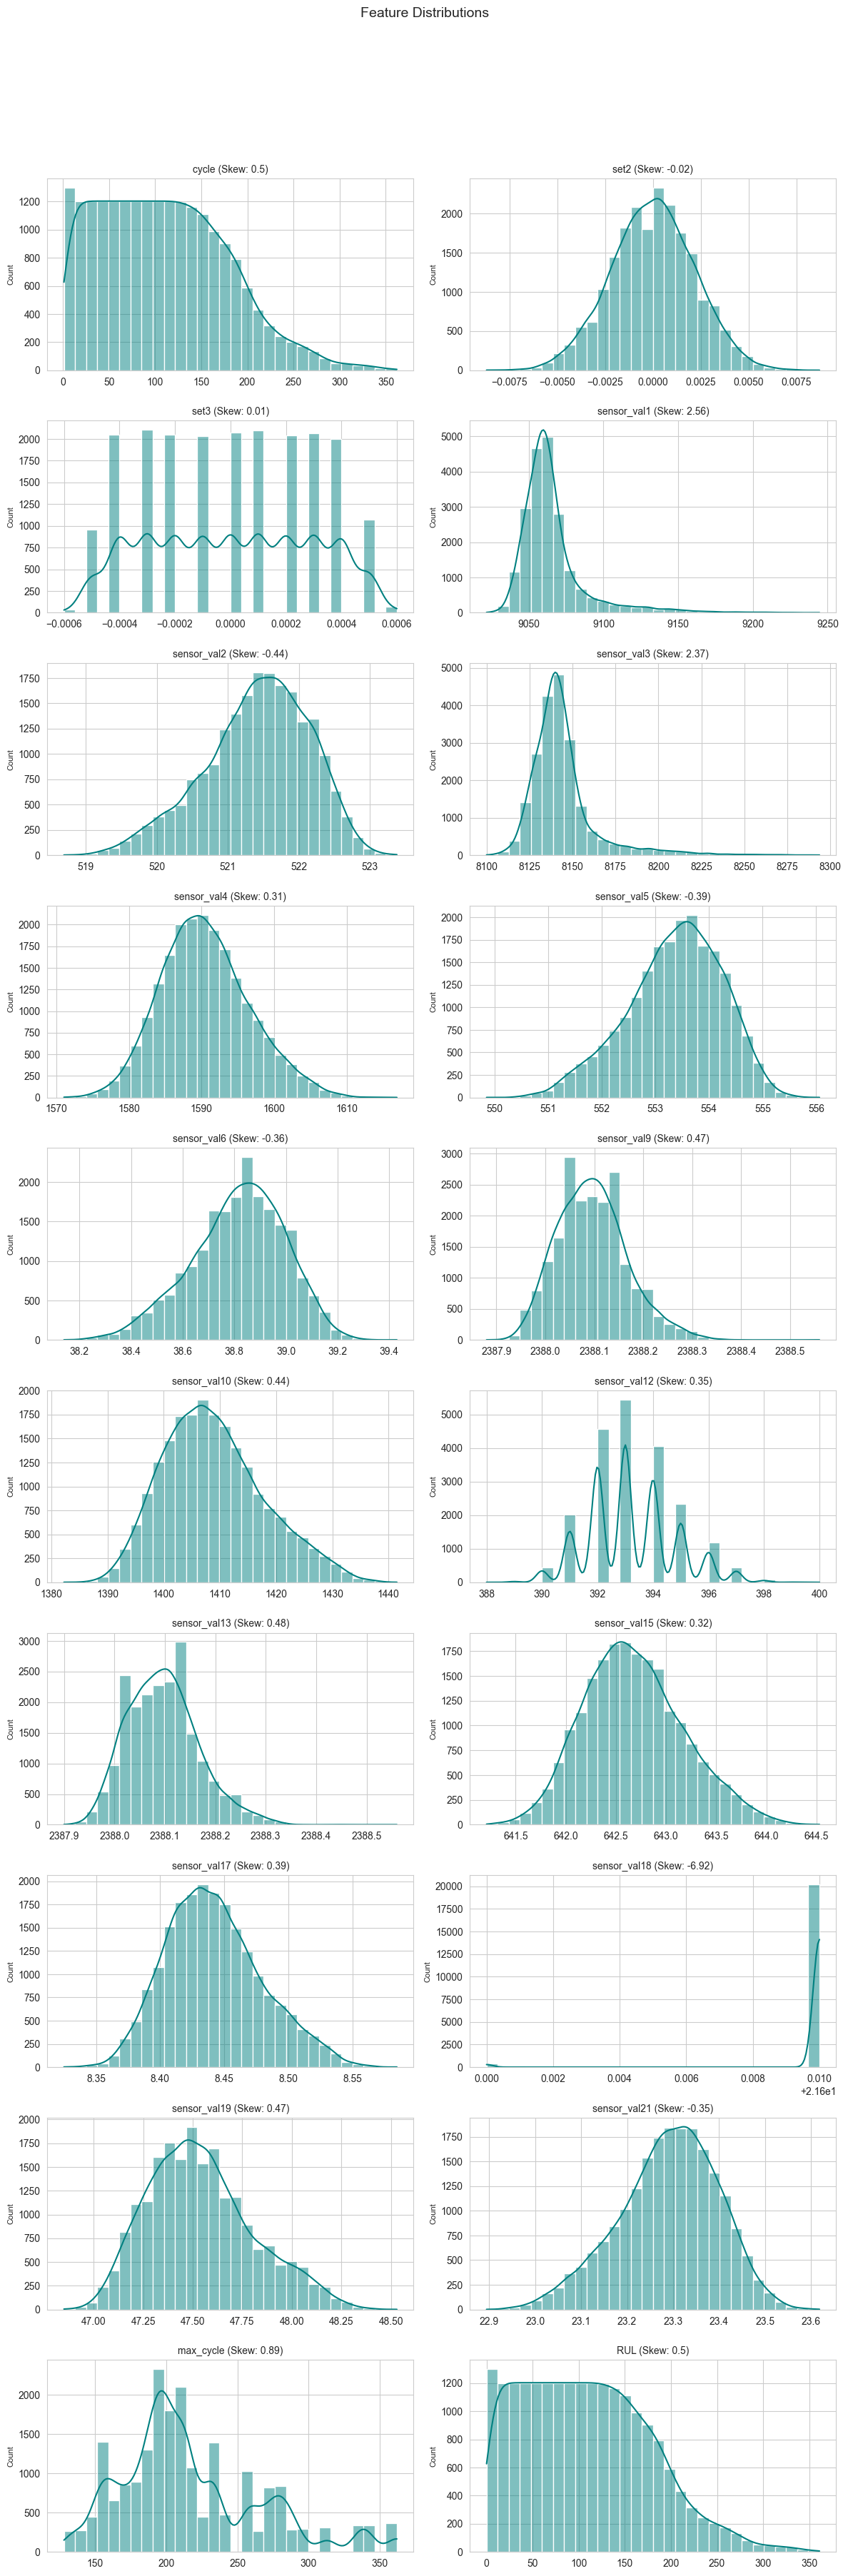

In [7]:
sns.set_style("whitegrid")
sns.set_palette("muted")

plt.figure(figsize=(12, len(key_features)*2))
for i, col in enumerate(key_features, 1):
    plt.subplot(len(key_features)//2 + 1, 2, i)
    sns.histplot(rul_data[col], kde=True, color="teal", bins=30)
    plt.title(f"{col} (Skew: {round(rul_data[col].skew(), 2)})", fontsize=10)
    plt.xlabel("")
    plt.ylabel("Count", fontsize=8)

plt.tight_layout()
plt.suptitle("Feature Distributions", fontsize=14)
plt.subplots_adjust(top=0.92)
plt.show()

In [8]:
# The columns above that seem to have a weird distribution are removed from the data
columns_to_remove = ["sensor_val8", "sensor_val14", "sensor_val20"]

In [9]:
key_features

['cycle',
 'set2',
 'set3',
 'sensor_val1',
 'sensor_val2',
 'sensor_val3',
 'sensor_val4',
 'sensor_val5',
 'sensor_val6',
 'sensor_val9',
 'sensor_val10',
 'sensor_val12',
 'sensor_val13',
 'sensor_val15',
 'sensor_val17',
 'sensor_val18',
 'sensor_val19',
 'sensor_val21',
 'max_cycle',
 'RUL']

In [10]:
low_var_cols

['set1',
 'sensor_val7',
 'sensor_val8',
 'sensor_val11',
 'sensor_val14',
 'sensor_val16',
 'sensor_val20']

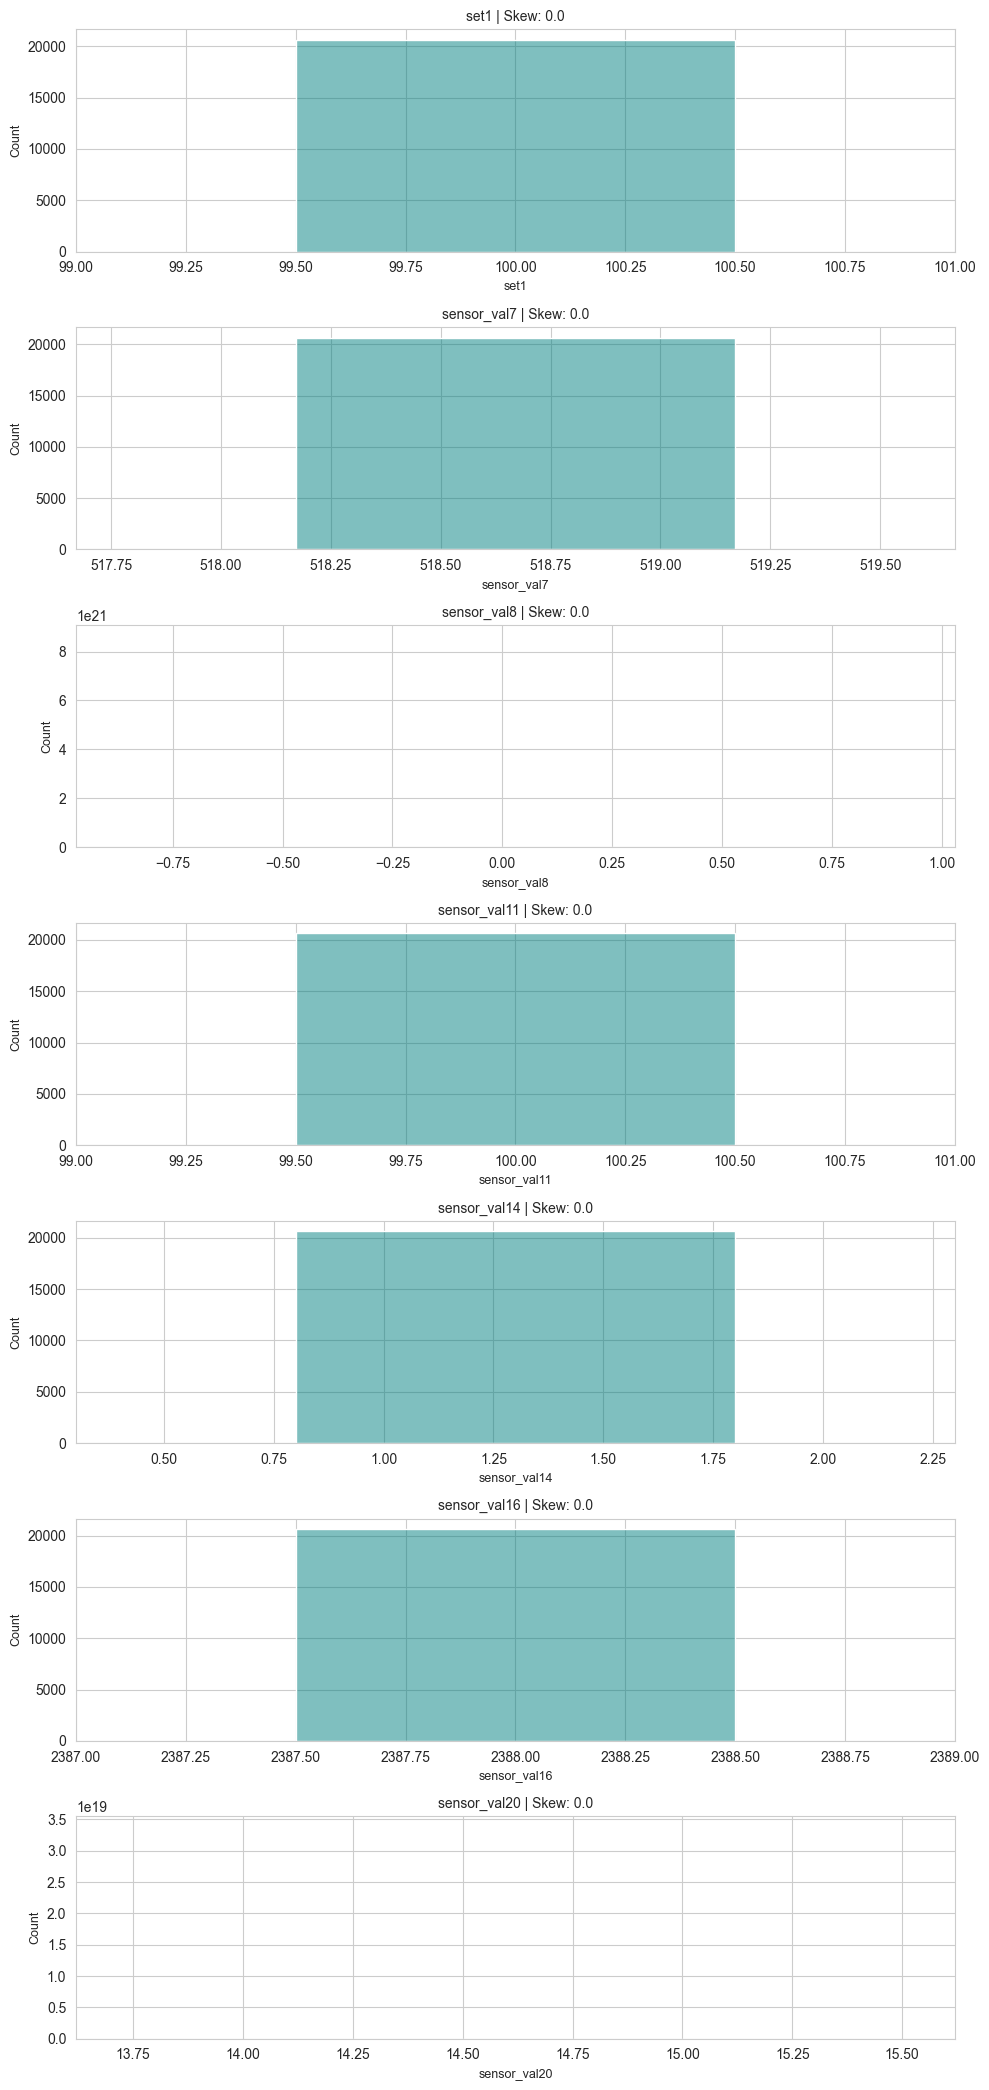

In [11]:
# Plot low variability features
if 'low_var_cols' in locals():
    n_rows = len(low_var_cols)
    plt.figure(figsize=(10, n_rows * 3))
    
    for idx, feature in enumerate(low_var_cols, 1):
        plt.subplot(n_rows, 1, idx)
        sns.histplot(rul_data[feature], kde=True, color="teal")
        plt.title(f"{feature} | Skew: {round(rul_data[feature].skew(), 2)}", fontsize=10)
        plt.xlabel(feature, fontsize=9)
        plt.ylabel("Count", fontsize=9)
        plt.xlim(rul_data[feature].min() - 1, rul_data[feature].max() + 1)  # Decrease x-axis range slightly
    
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'low_var_cols' not defined.")


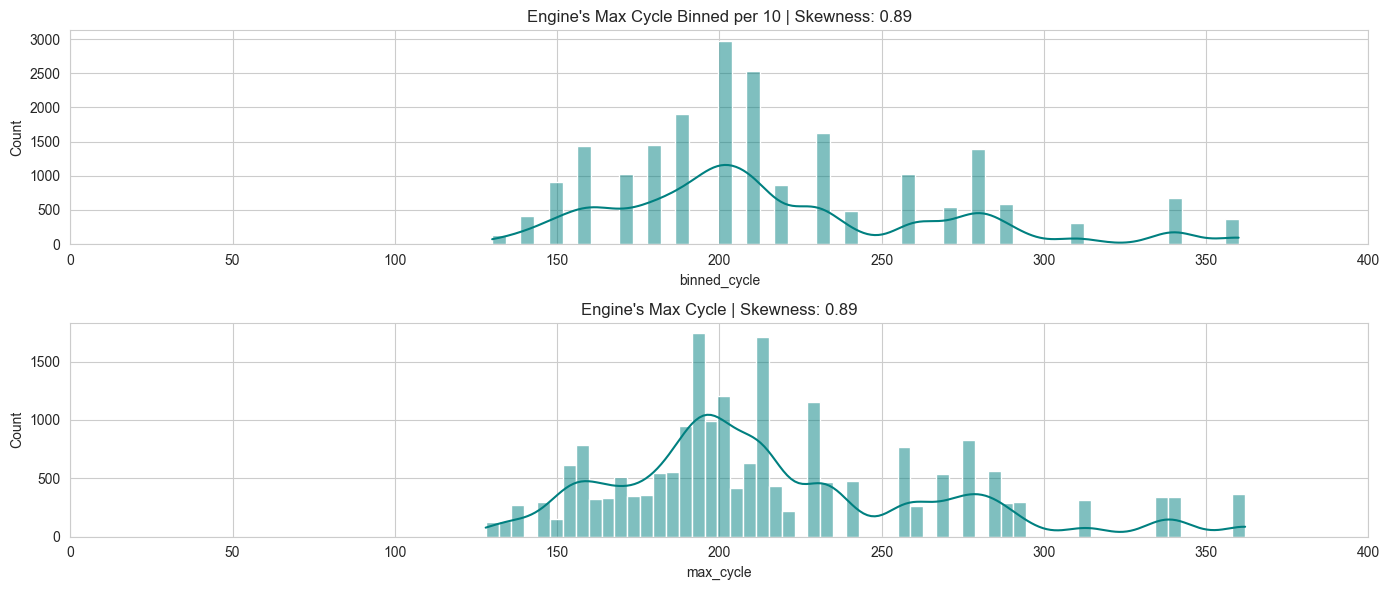

In [12]:
# Add a new column with binned max_cycle values
rul_data['binned_cycle'] = np.round(rul_data['max_cycle'], decimals=-1)

# Define columns to visualize
columns_to_visualize = ['binned_cycle', 'max_cycle']

# Create a figure for the plots
plt.figure(figsize=(14, len(columns_to_visualize) * 3))

# Plot binned_cycle
plt.subplot(len(columns_to_visualize), 1, 1)
sns.histplot(rul_data['binned_cycle'], kde=True, color="teal")
plt.title(f"Engine's Max Cycle Binned per 10 | Skewness: {round(rul_data['binned_cycle'].skew(), 2)}")
plt.xlim(0, 400)

# Plot max_cycle
plt.subplot(len(columns_to_visualize), 1, 2)
sns.histplot(rul_data['max_cycle'], kde=True, color="teal")
plt.title(f"Engine's Max Cycle | Skewness: {round(rul_data['max_cycle'].skew(), 2)}")
plt.xlim(0, 400)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [13]:
rul_data.aggregate({"max_cycle": ["min", "mean", "median", "max"]}), rul_data


(         max_cycle
 min     128.000000
 mean    216.615724
 median  207.000000
 max     362.000000,
        engine_id  cycle   set1    set2    set3  sensor_val1  sensor_val2  \
 0              1      1  100.0 -0.0007 -0.0004      9046.19       521.66   
 1              1      2  100.0  0.0019 -0.0003      9044.07       522.28   
 2              1      3  100.0 -0.0043  0.0003      9052.94       522.42   
 3              1      4  100.0  0.0007  0.0000      9049.48       522.86   
 4              1      5  100.0 -0.0019 -0.0002      9055.15       522.19   
 ...          ...    ...    ...     ...     ...          ...          ...   
 20626        100    196  100.0 -0.0004 -0.0003      9065.52       519.49   
 20627        100    197  100.0 -0.0016 -0.0005      9065.11       519.68   
 20628        100    198  100.0  0.0004  0.0000      9065.90       520.01   
 20629        100    199  100.0 -0.0011  0.0003      9073.72       519.67   
 20630        100    200  100.0 -0.0032 -0.0005     

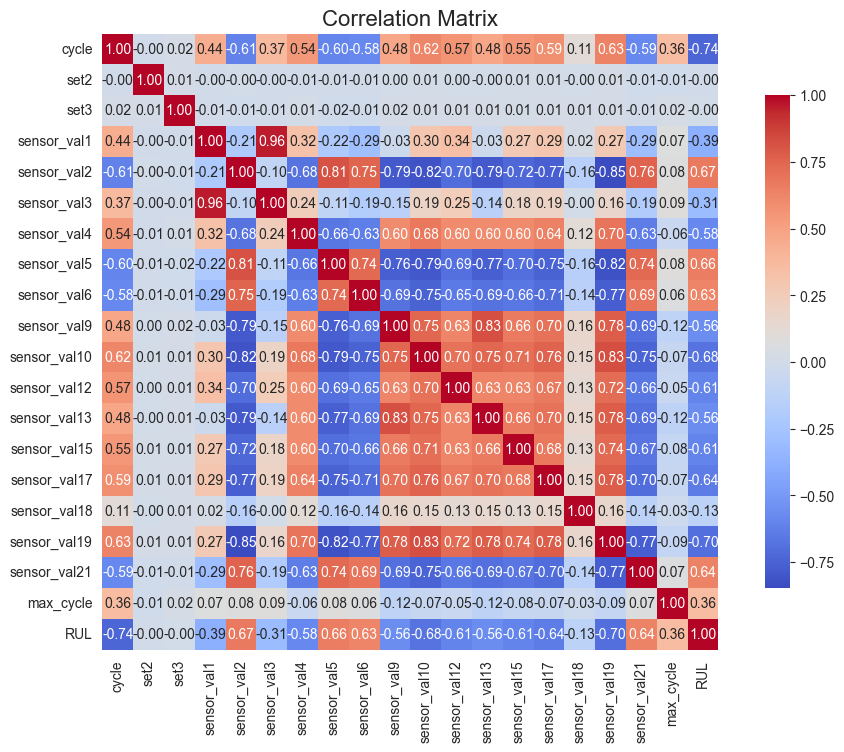

In [14]:
# create co relationship matrix of important features
def plot_correlation_matrix(df, features):
    """
    Plot the correlation matrix for the given features.
    
    Parameters:
    - df: DataFrame containing the data
    - features: List of feature names to include in the correlation matrix
    """
    plt.figure(figsize=(12, 8))
    corr = df[features].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix", fontsize=16)
    plt.show()
# Plot correlation matrix for key features
plot_correlation_matrix(rul_data, key_features)

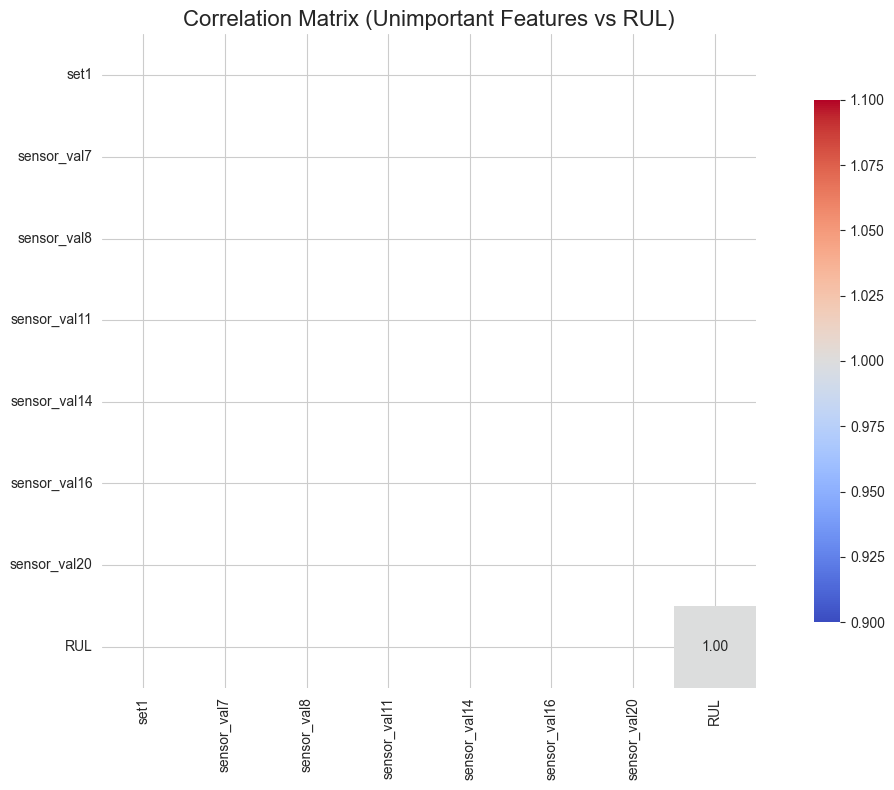

In [15]:
def plot_correlation_matrix_unimportant(df, features, rul_column='RUL'):
    """
    Plot the correlation matrix between the unimportant features and RUL.

    Parameters:
    - df: DataFrame containing the data
    - features: List of unimportant (e.g., low-variance) feature names
    - rul_column: Name of the column containing RUL values (default: 'RUL')
    """
    plt.figure(figsize=(12, 8))
    
    # Include RUL in the list of features for correlation
    cols = features + [rul_column]
    
    # Compute the correlation matrix
    corr = df[cols].corr()
    
    # Plot the heatmap
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    
    plt.title(f"Correlation Matrix (Unimportant Features vs {rul_column})", fontsize=16)
    plt.tight_layout()
    plt.show

plot_correlation_matrix_unimportant(rul_data, low_var_cols)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_

/var/folders/w5/1rs1frbd3dz2ny_42y5sqjpw0000gn/T/ipykernel_13713/3185448726.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')


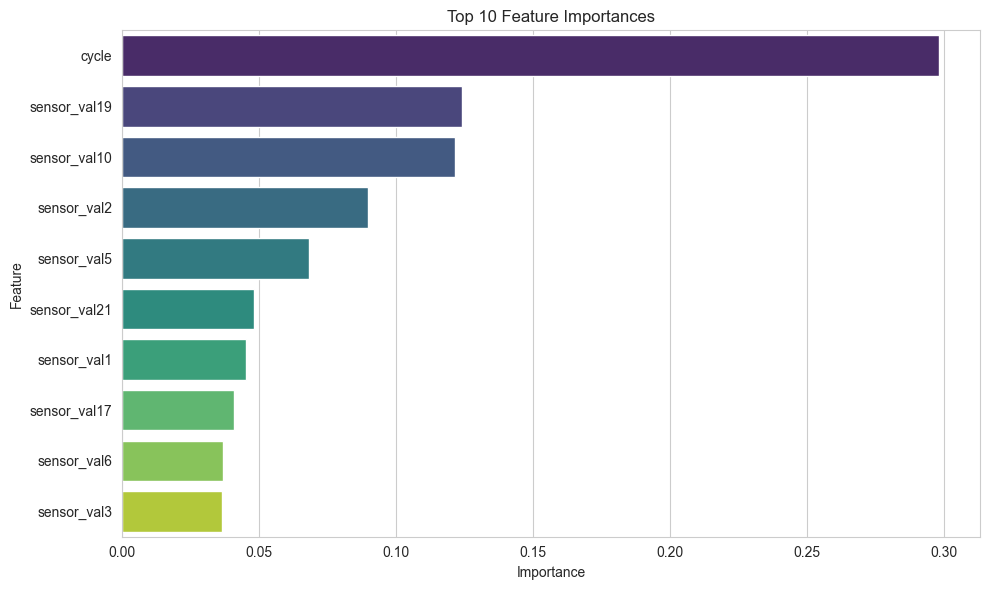

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define features (X) and target (y)
X = rul_data[key_features].drop(columns=['max_cycle', 'RUL'], errors='ignore')  # Exclude 'max_cycle' and 'RUL' from features
y = rul_data['RUL']  # Target variable

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Use GridSearchCV (always works)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train_val, y_train_val)

# Best model and evaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)
print(f"Best Params: {grid_search.best_params_}")
print(f"Test RMSE: {rmse:.4f}, Test R²: {r2:.4f}")

# Feature Importance Analysis
importances = best_rf.feature_importances_
features = X.columns if isinstance(X, pd.DataFrame) else [f"feat_{i}" for i in range(X.shape[1])]
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [17]:
y_pred = round(pd.Series(y_pred), 0)
y_pred

0       107.0
1        10.0
2       201.0
3         2.0
4       120.0
        ...  
4122    199.0
4123     95.0
4124    125.0
4125    124.0
4126    104.0
Length: 4127, dtype: float64

In [18]:
import copy

# Load schedule data
data_schedule = pd.read_csv('DataSchedule.csv')

# Define columns to use (only key features, excluding RUL and max_cycle)
# key_features already excludes low-variance columns (sensor_val8, sensor_val14, sensor_val20)
columns_to_use = copy.copy(key_features)

# Explicitly remove RUL and max_cycle (not input features)
try:
    columns_to_use.remove("RUL")
    columns_to_use.remove("max_cycle")
except ValueError:
    pass  # Handle cases where columns are not present

# Extract relevant features for prediction
important_data_schedule = data_schedule[columns_to_use]
important_data_schedule

,cycle,set2,set3,sensor_val1,sensor_val2,sensor_val3,sensor_val4,sensor_val5,sensor_val6,sensor_val9,sensor_val10,sensor_val12,sensor_val13,sensor_val15,sensor_val17,sensor_val18,sensor_val19,sensor_val21
0,1,0.0023,0.0003,9050.17,521.72,8125.55,1585.29,553.90,38.86,2388.03,1398.21,392,2388.04,643.02,8.4052,21.61,47.20,23.3735
1,2,-0.0027,-0.0003,9054.42,522.16,8139.62,1588.45,554.85,39.02,2388.06,1395.42,393,2388.01,641.71,8.3803,21.61,47.50,23.3916
2,3,0.0003,0.0001,9056.96,521.97,8130.10,1586.94,554.11,39.08,2388.03,1401.34,393,2388.05,642.46,8.4441,21.61,47.50,23.4166
3,4,0.0042,0.0000,9045.29,521.38,8132.90,1584.12,554.07,39.00,2388.05,1406.42,391,2388.03,642.44,8.3917,21.61,47.28,23.3737
4,5,0.0014,0.0000,9044.55,522.15,8129.54,1587.19,554.16,38.99,2388.03,1401.92,390,2388.01,642.51,8.4031,21.61,47.31,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,194,0.0049,0.0000,9142.37,520.69,8213.28,1599.45,553.41,38.65,2388.00,1415.79,394,2388.02,643.24,8.4715,21.61,47.69,23.1974
13092,195,-0.0011,-0.0001,9140.68,521.05,8210.85,1595.69,553.22,38.57,2388.09,1422.05,395,2388.05,643.22,8.4512,21.61,47.60,23.2771
13093,196,-0.0006,-0.0003,9146.81,521.18,8217.24,1593.15,553.04,38.62,2388.04,1406.82,395,2388.11,643.44,8.4569,21.61,47.57,23.2051
13094,197,-0.0038,0.0001,9148.85,521.33,8220.48,1594.99,553.37,38.66,2388.08,1419.36,395,2388.07,643.26,8.4711,21.61,47.61,23.2699


In [19]:
# Predict RUL on schedule data
y_pred_schedule = best_rf.predict(important_data_schedule)

# Round predictions to nearest integer and convert to Series
y_pred_schedule = round(pd.Series(y_pred_schedule), 0)

# Optional: Ensure non-negative predictions (RUL cannot be negative)
y_pred_schedule = y_pred_schedule.apply(lambda x: max(0, x))

y_pred_schedule

0        197.0
1        209.0
2        200.0
3        203.0
4        213.0
         ...  
13091     25.0
13092     28.0
13093     30.0
13094     28.0
13095     19.0
Length: 13096, dtype: float64

In [20]:
# Combine schedule data with predictions (reset index to ensure alignment)
combined_predict_schedule = pd.concat([
    data_schedule.reset_index(drop=True), 
    y_pred_schedule.reset_index(drop=True)
], axis=1)

# Rename prediction column explicitly
combined_predict_schedule = combined_predict_schedule.rename(columns={0: "RUL"})

# Filter for engine_id == 1 with clean index
engine_1_results = combined_predict_schedule[combined_predict_schedule["engine_id"] == 1].reset_index(drop=True)

engine_1_results

,engine_id,cycle,set1,set2,set3,sensor_val1,sensor_val2,sensor_val3,sensor_val4,sensor_val5,...,sensor_val13,sensor_val14,sensor_val15,sensor_val16,sensor_val17,sensor_val18,sensor_val19,sensor_val20,sensor_val21,RUL
0,1,1,100.0,0.0023,0.0003,9050.17,521.72,8125.55,1585.29,553.90,...,2388.04,1.3,643.02,2388,8.4052,21.61,47.20,14.62,23.3735,197.0
1,1,2,100.0,-0.0027,-0.0003,9054.42,522.16,8139.62,1588.45,554.85,...,2388.01,1.3,641.71,2388,8.3803,21.61,47.50,14.62,23.3916,209.0
2,1,3,100.0,0.0003,0.0001,9056.96,521.97,8130.10,1586.94,554.11,...,2388.05,1.3,642.46,2388,8.4441,21.61,47.50,14.62,23.4166,200.0
3,1,4,100.0,0.0042,0.0000,9045.29,521.38,8132.90,1584.12,554.07,...,2388.03,1.3,642.44,2388,8.3917,21.61,47.28,14.62,23.3737,203.0
4,1,5,100.0,0.0014,0.0000,9044.55,522.15,8129.54,1587.19,554.16,...,2388.01,1.3,642.51,2388,8.4031,21.61,47.31,14.62,23.4130,213.0
5,1,6,100.0,0.0012,0.0003,9050.96,521.92,8127.46,1579.12,554.22,...,2388.00,1.3,642.11,2388,8.4238,21.61,47.26,14.62,23.3467,207.0
6,1,7,100.0,-0.0000,0.0002,9051.39,522.01,8134.97,1583.34,553.89,...,2388.05,1.3,642.11,2388,8.3914,21.61,47.31,14.62,23.3952,209.0
7,1,8,100.0,0.0006,-0.0000,9052.86,522.09,8125.93,1580.89,553.59,...,2388.05,1.3,642.54,2388,8.4213,21.61,47.21,14.62,23.3224,196.0
8,1,9,100.0,-0.0036,0.0000,9048.55,522.03,8134.15,1593.29,554.49,...,2388.06,1.3,641.88,2388,8.4353,21.61,47.37,14.62,23.4521,203.0
9,1,10,100.0,-0.0025,-0.0001,9051.95,522.00,8134.08,1585.25,554.28,...,2388.04,1.3,642.07,2388,8.4093,21.61,47.14,14.62,23.3820,206.0


In [21]:
# Group by engine_id and compute mean RUL per engine
average_RUL = (
    combined_predict_schedule
    .groupby("engine_id", as_index=False)  # Keep 'engine_id' as a column
    .agg({"RUL": "mean"})  # Only compute mean for RUL column
)

# Round to 0 decimal places (converts float to integer-like values)
rounded_average_RUL = average_RUL.round(0)

# Optional: Convert to integer type if needed (e.g., no decimal points)
rounded_average_RUL["RUL"] = rounded_average_RUL["RUL"].astype(int)

# Display results
rounded_average_RUL

,engine_id,RUL
0,1,197
1,2,171
2,3,129
3,4,144
4,5,147
...,...,...
95,96,168
96,97,147
97,98,140
98,99,175


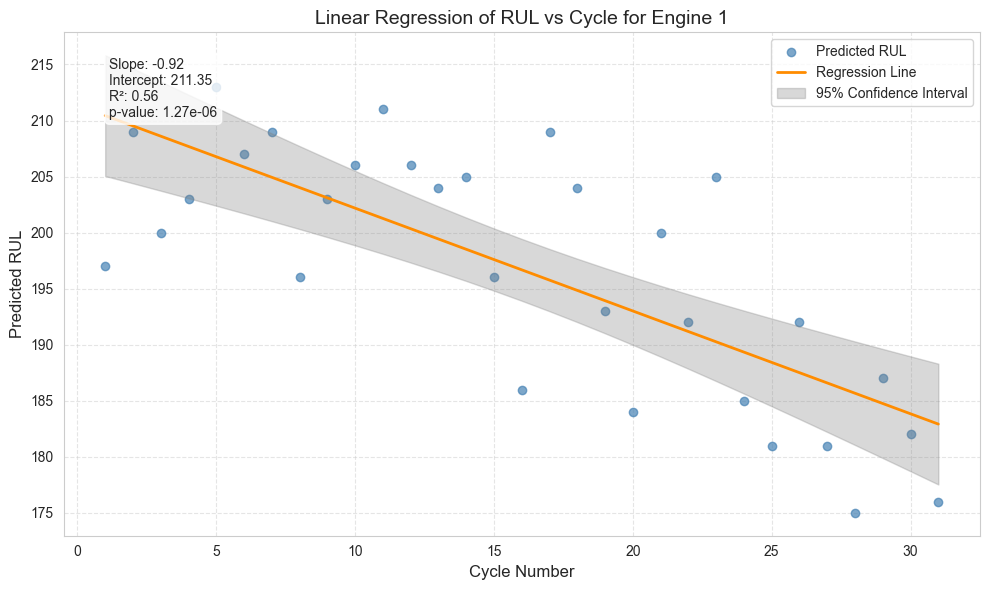

In [22]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

# Filter data for engine_id = 1
engine_id = 1
engine_data = combined_predict_schedule[combined_predict_schedule["engine_id"] == engine_id]

# Extract variables
x = engine_data["cycle"].values
y = engine_data["RUL"].values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

# Predict y values
y_pred = slope * x + intercept

# Calculate residuals and mean squared error (MSE)
residuals = y - y_pred
mse = np.sum(residuals**2) / (len(x) - 2)

# Compute x mean and sum of squared deviations (Sxx)
x_mean = np.mean(x)
Sxx = np.sum((x - x_mean)**2)

# t-critical value for 95% confidence interval
t_crit = scipy.stats.t.ppf(0.975, len(x) - 2)

# Calculate confidence intervals
ci_lower = []
ci_upper = []
for xi in x:
    se = np.sqrt(mse * (1/len(x) + ((xi - x_mean)**2) / Sxx))
    ci = t_crit * se
    ci_lower.append(slope * xi + intercept - ci)
    ci_upper.append(slope * xi + intercept + ci)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Predicted RUL", color="steelblue", alpha=0.7)
plt.plot(x, y_pred, color="darkorange", linewidth=2, label="Regression Line")
plt.fill_between(x, ci_lower, ci_upper, color="gray", alpha=0.3, label="95% Confidence Interval")

# Annotate key statistics
plt.text(
    0.05, 0.95,
    f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR²: {r_value**2:.2f}\np-value: {p_value:.2e}",
    transform=plt.gca().transAxes,
    fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# Labels and legend
plt.title(f"Linear Regression of RUL vs Cycle for Engine {engine_id}", fontsize=14)
plt.xlabel("Cycle Number", fontsize=12)
plt.ylabel("Predicted RUL", fontsize=12)
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [23]:
from scipy.stats import linregress, t
import numpy as np

def calculate_RUL_for_last_cycle_confidence(df):
    """
    This function will perform a linear regression for each engine_id and try to approximate a line that fits the RUL values for each engine_id. 
    We will then take the RUL value of the line that is at the location of the last_cycle number for each engine_id
    :param df: DataFrame with ['engine_id', 'cycle', 'RUL'] columns
    :return: Dictionary {engine_id: predicted_RUL_lower_bound}
    """
    engine_ids = df['engine_id'].unique()
    predicted_RUL_dict = {}
    
    # Define tinv inside function to avoid lambda confusion
    def tinv(p, df):
        return abs(t.ppf(p/2, df))  # Two-tailed t-value

    for engine_id in engine_ids:
        cycle_data = df[df['engine_id'] == engine_id]
        
        # Skip if not enough data points
        if len(cycle_data) < 2:
            predicted_RUL_dict[int(engine_id)] = np.nan
            continue
            
        # Get x/y values
        x = cycle_data['cycle'].values
        y = cycle_data['RUL'].values
        
        # Perform linear regression
        result = linregress(x, y)
        
        # Calculate t-value for 95% confidence
        ts = tinv(0.05, len(x) - 2)  # p=0.05 for 95% CI
        
        # Get last cycle value
        last_cycle = cycle_data['cycle'].iloc[-1]
        
        # Debug output for engine_id == 1
        if engine_id == 1:
            print(f"slope (95%): {result.slope:.6f} +/- {ts*result.stderr:.6f}")
            print(f"minimal slope (95%): {result.slope - ts*result.stderr:.6f}")
            print(f"maximal slope (95%): {result.slope + ts*result.stderr:.6f}")
            print(f"intercept (95%): {result.intercept:.6f}")
            print(f"minimal intercept (95%): {result.intercept - ts*result.intercept_stderr:.6f}")
            print(f"maximal intercept (95%): {result.intercept + ts*result.intercept_stderr:.6f}")
            print(f"RUL for last cycle: {result.slope*last_cycle + result.intercept:.6f}")
            print(f" +/- {ts*result.intercept_stderr:.6f}")
            print("minimal RUList: ", (result.slope - ts*result.stderr) * last_cycle + (result.intercept - ts*result.intercept_stderr))
        
        # Calculate lower confidence bound estimate
        lower_bound = (result.slope - ts*result.stderr) * last_cycle + (result.intercept - ts*result.intercept_stderr)
        
        # Store rounded, non-negative value
        predicted_RUL_dict[int(engine_id)] = max(0, round(lower_bound))
        
    return predicted_RUL_dict

rul_dict = calculate_RUL_for_last_cycle_confidence(combined_predict_schedule)
rul_dict

slope (95%): -0.917339 +/- 0.308451
minimal slope (95%): -1.225790
maximal slope (95%): -0.608888
intercept (95%): 211.354839
minimal intercept (95%): 205.700839
maximal intercept (95%): 217.008838
RUL for last cycle: 182.917339
 +/- 5.654000
minimal RUList:  167.7013589290788


{1: 168,
 2: 146,
 3: 60,
 4: 86,
 5: 96,
 6: 93,
 7: 97,
 8: 68,
 9: 138,
 10: 92,
 11: 96,
 12: 92,
 13: 92,
 14: 132,
 15: 138,
 16: 115,
 17: 45,
 18: 75,
 19: 102,
 20: 30,
 21: 84,
 22: 152,
 23: 127,
 24: 21,
 25: 155,
 26: 128,
 27: 103,
 28: 75,
 29: 83,
 30: 65,
 31: 14,
 32: 55,
 33: 132,
 34: 32,
 35: 7,
 36: 21,
 37: 71,
 38: 48,
 39: 164,
 40: 27,
 41: 65,
 42: 38,
 43: 65,
 44: 141,
 45: 58,
 46: 35,
 47: 110,
 48: 119,
 49: 50,
 50: 126,
 51: 80,
 52: 50,
 53: 35,
 54: 118,
 55: 110,
 56: 4,
 57: 67,
 58: 56,
 59: 133,
 60: 74,
 61: 49,
 62: 68,
 63: 59,
 64: 46,
 65: 144,
 66: 9,
 67: 132,
 68: 22,
 69: 143,
 70: 74,
 71: 132,
 72: 80,
 73: 122,
 74: 77,
 75: 115,
 76: 19,
 77: 52,
 78: 150,
 79: 102,
 80: 73,
 81: 14,
 82: 30,
 83: 128,
 84: 52,
 85: 156,
 86: 81,
 87: 151,
 88: 120,
 89: 71,
 90: 38,
 91: 8,
 92: 13,
 93: 30,
 94: 54,
 95: 121,
 96: 123,
 97: 85,
 98: 69,
 99: 131,
 100: 25}

In [24]:
# Get all RUL values < 30 (with engine IDs)
low_rul_engines = {k: v for k, v in rul_dict.items() if 0 < v < 30}

# Get only the values (no engine IDs)
low_rul_values = [v for v in low_rul_engines.values()]

# Print results
print("Engines with RUL < 30:")
for engine_id, rul in low_rul_engines.items():
    print(f"Engine {engine_id}: RUL = {rul}")

print("\nRUL values < 30:", low_rul_values)

Engines with RUL < 30:
Engine 24: RUL = 21
Engine 31: RUL = 14
Engine 35: RUL = 7
Engine 36: RUL = 21
Engine 40: RUL = 27
Engine 56: RUL = 4
Engine 66: RUL = 9
Engine 68: RUL = 22
Engine 76: RUL = 19
Engine 81: RUL = 14
Engine 91: RUL = 8
Engine 92: RUL = 13
Engine 100: RUL = 25

RUL values < 30: [21, 14, 7, 21, 27, 4, 9, 22, 19, 14, 8, 13, 25]


In [25]:
from scipy.stats import linregress, t
import numpy as np

def find_predicted_last_RUL_regression(df):
    """
    Perform linear regression for each engine and return conservative RUL estimate (lower confidence bound).
    
    Parameters:
    - df: DataFrame with ['engine_id', 'cycle', 'RUL'] columns
    
    Returns:
    - Dictionary: {engine_id: predicted_RUL_lower_bound}
    """
    engine_ids = df['engine_id'].unique()
    predicted_RUL_dict = {}

    for engine_id in engine_ids:
        cycle_data = df[df['engine_id'] == engine_id].copy()
        
        # Skip engines with insufficient data
        if len(cycle_data) < 2:
            predicted_RUL_dict[int(engine_id)] = np.nan
            continue
            
        x = cycle_data['cycle'].values
        y = cycle_data['RUL'].values
        
        # Perform linear regression
        result = linregress(x, y)
        
        # Calculate t-critical value for 95% confidence
        ts = t.ppf(0.975, len(x) - 2)  # 95% confidence level
        
        # Get last cycle value
        last_cycle = cycle_data['cycle'].iloc[-1]
        
        # Calculate lower confidence bound (conservative estimate)
        slope_error = ts * result.stderr
        intercept_error = ts * result.intercept_stderr
        
        # Predicted RUL with confidence bounds
        predicted_RUL = result.slope * last_cycle + result.intercept
        lower_bound = (result.slope - slope_error) * last_cycle + (result.intercept - intercept_error)
        
        # Store rounded lower bound as conservative estimate
        predicted_RUL_dict[int(engine_id)] = max(0, round(lower_bound))
        
        # Debug output for engine_id == 1
        if engine_id == 1:
            print(f"Engine {engine_id} Analysis:")
            print(f"Slope (95%): {result.slope:.6f} ± {slope_error:.6f}")
            print(f"Intercept (95%): {result.intercept:.6f} ± {intercept_error:.6f}")
            print(f"Predicted RUL: {predicted_RUL:.2f}")
            print(f"Lower Bound (95%): {lower_bound:.2f}")
            print(f"Used Lower Bound: {predicted_RUL_dict[int(engine_id)]}\n")

    return predicted_RUL_dict

# Example usage
predicted_RUL_dict = find_predicted_last_RUL_regression(combined_predict_schedule)

# Filter RUL values < 30
low_rul_engines = {k: v for k, v in predicted_RUL_dict.items() if 0 < v < 30}

# Print results
print("Engines with RUL < 30:")
for engine_id, rul in low_rul_engines.items():
    print(f"Engine {engine_id}: RUL = {rul}")

Engine 1 Analysis:
Slope (95%): -0.917339 ± 0.308451
Intercept (95%): 211.354839 ± 5.654000
Predicted RUL: 182.92
Lower Bound (95%): 167.70
Used Lower Bound: 168

Engines with RUL < 30:
Engine 24: RUL = 21
Engine 31: RUL = 14
Engine 35: RUL = 7
Engine 36: RUL = 21
Engine 40: RUL = 27
Engine 56: RUL = 4
Engine 66: RUL = 9
Engine 68: RUL = 22
Engine 76: RUL = 19
Engine 81: RUL = 14
Engine 91: RUL = 8
Engine 92: RUL = 13
Engine 100: RUL = 25


In [26]:
# Assuming combined_predict_schedule is predefined and contains the necessary data
from sklearn.linear_model import LinearRegression
from scipy import stats

def find_predicted_last_RUL_regression(df):
    """
    This function will perform a linear regression for each engine_id and try to approximate a line that fits the RUL values for each engine_id. We will then take the RUL value of the line that is at the location of the last_cycle number for each engine_id
    :param df: 
    :return: 
    """
    engine_ids = df['engine_id'].unique()
    predicted_RUL_dict = {}
    for engine_id in engine_ids:
        cycle_data = df[df['engine_id'] == engine_id]
        slope, intercept, r_value, p_value, std_err = stats.linregress(cycle_data['cycle'], cycle_data['RUL'])

        last_cycle_rul = slope * cycle_data['cycle'].iloc[-1] + intercept
        predicted_RUL_dict[int(engine_id)] = int(round(last_cycle_rul))

    return predicted_RUL_dict

# Original function call (unchanged)
predicted_RUL_dict = find_predicted_last_RUL_regression(combined_predict_schedule)

# New: Filter RUL values < 30 (matches your rul_dict logic)
low_rul_engines = {k: v for k, v in predicted_RUL_dict.items() if v < 30}

# Output both dictionaries
predicted_RUL_dict, low_rul_engines

({1: 183,
  2: 153,
  3: 66,
  4: 93,
  5: 102,
  6: 100,
  7: 104,
  8: 76,
  9: 145,
  10: 100,
  11: 105,
  12: 100,
  13: 100,
  14: 145,
  15: 148,
  16: 123,
  17: 53,
  18: 83,
  19: 109,
  20: 37,
  21: 92,
  22: 164,
  23: 135,
  24: 29,
  25: 170,
  26: 137,
  27: 111,
  28: 84,
  29: 91,
  30: 72,
  31: 20,
  32: 65,
  33: 140,
  34: 43,
  35: 13,
  36: 31,
  37: 82,
  38: 55,
  39: 177,
  40: 36,
  41: 78,
  42: 51,
  43: 74,
  44: 154,
  45: 67,
  46: 42,
  47: 121,
  48: 128,
  49: 59,
  50: 136,
  51: 89,
  52: 60,
  53: 44,
  54: 126,
  55: 119,
  56: 15,
  57: 75,
  58: 64,
  59: 141,
  60: 82,
  61: 56,
  62: 76,
  63: 66,
  64: 54,
  65: 154,
  66: 16,
  67: 142,
  68: 30,
  69: 152,
  70: 83,
  71: 141,
  72: 87,
  73: 130,
  74: 85,
  75: 126,
  76: 26,
  77: 61,
  78: 160,
  79: 111,
  80: 81,
  81: 21,
  82: 39,
  83: 140,
  84: 60,
  85: 164,
  86: 92,
  87: 163,
  88: 128,
  89: 81,
  90: 46,
  91: 16,
  92: 21,
  93: 39,
  94: 62,
  95: 131,
  96: 131,
  97: 9

In [27]:
# Filtered dictionary: {engine_id: RUL} where RUL < 30 and RUL > 0
low_rul_engines = {k: v for k, v in predicted_RUL_dict.items() if 0 < v < 30}

# List of values only
rul_under_30 = list(low_rul_engines.values())

# Print results
print("Engines with RUL < 30:")
for engine_id, rul in low_rul_engines.items():
    print(f"Engine {engine_id}: RUL = {rul}")

Engines with RUL < 30:
Engine 24: RUL = 29
Engine 31: RUL = 20
Engine 35: RUL = 13
Engine 56: RUL = 15
Engine 66: RUL = 16
Engine 76: RUL = 26
Engine 81: RUL = 21
Engine 91: RUL = 16
Engine 92: RUL = 21


In [32]:

import json

# Save dictionary to text file as JSON
with open("predicted_RUL_dict.txt", "w") as file:
    file.write(json.dumps(rul_dict))

# Load dictionary from text file (done twice in your original code)
with open("predicted_RUL_dict.txt", "r") as file:
    our_predicted_json = json.loads(file.read())

with open("predicted_RUL_dict.txt", "r") as file:
    our_predicted_json = json.loads(file.read())  # Redundant second load


In [34]:

# Read consultancy data (using semicolon separator)
data_consultancy = pd.read_csv("RUL_consultancy_predictions_A3.csv", sep=";")

# Convert consultancy RUL to dictionary format
data_consultancy.to_dict()["RUL"]

{0: 135,
 1: 125,
 2: 63,
 3: 100,
 4: 103,
 5: 122,
 6: 106,
 7: 90,
 8: 121,
 9: 67,
 10: 101,
 11: 89,
 12: 87,
 13: 122,
 14: 114,
 15: 101,
 16: 52,
 17: 33,
 18: 84,
 19: 10,
 20: 63,
 21: 141,
 22: 119,
 23: 26,
 24: 173,
 25: 128,
 26: 70,
 27: 96,
 28: 96,
 29: 87,
 30: 14,
 31: 54,
 32: 128,
 33: 8,
 34: 8,
 35: 24,
 36: 21,
 37: 58,
 38: 144,
 39: 29,
 40: 23,
 41: 13,
 42: 67,
 43: 146,
 44: 100,
 45: 53,
 46: 130,
 47: 151,
 48: 14,
 49: 100,
 50: 106,
 51: 34,
 52: 34,
 53: 126,
 54: 174,
 55: 18,
 56: 102,
 57: 38,
 58: 113,
 59: 112,
 60: 23,
 61: 54,
 62: 75,
 63: 24,
 64: 152,
 65: 18,
 66: 174,
 67: 13,
 68: 130,
 69: 90,
 70: 130,
 71: 59,
 72: 113,
 73: 115,
 74: 115,
 75: 3,
 76: 27,
 77: 165,
 78: 82,
 79: 84,
 80: 6,
 81: 11,
 82: 182,
 83: 53,
 84: 142,
 85: 113,
 86: 126,
 87: 117,
 88: 111,
 89: 28,
 90: 29,
 91: 24,
 92: 51,
 93: 55,
 94: 143,
 95: 140,
 96: 109,
 97: 87,
 98: 127,
 99: 24}

In [37]:
# we want to compare the our_predicted_json with the consultancy predictions
consultancy_predictions = data_consultancy.to_dict()["RUL"]
our_predictions = our_predicted_json

# we will calculate the mean absolute error and the mean squared error
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(list(consultancy_predictions.values()), list(our_predictions.values()))
mse = mean_squared_error(list(consultancy_predictions.values()), list(our_predictions.values()))

#standard deviation difference between the two predictions
# difference between each of the predictions of the two datasets
abs_diff_in_predictions = [np.abs(con_pred-our_pred) for con_pred, our_pred in zip(consultancy_predictions.values(), our_predictions.values())]

diff_in_predictions = [con_pred-our_pred for con_pred, our_pred in zip(consultancy_predictions.values(), our_predictions.values())]

std = np.std(abs_diff_in_predictions)


print(f"mean absolute error = {mae} \nmean squared error  = {mse} \nstd difference predictions  = {std}")


mean absolute error = 17.61 
mean squared error  = 481.35 
std difference predictions  = 13.085790002900092


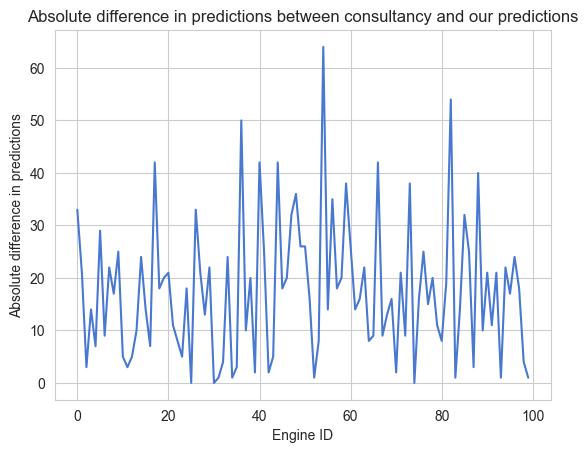

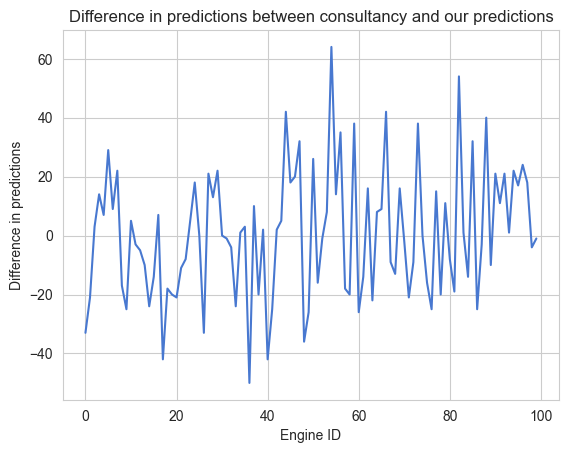

mean difference in predictions = 0.63
mean absolute difference in predictions = 17.61


In [43]:
# we will plot the difference in predictions
consultancy_predictions = data_consultancy.to_dict()["RUL"]
our_predictions = our_predicted_json

# Convert JSON string keys to integers for proper alignment
our_predictions = {int(k): v for k, v in our_predictions.items()}

abs_diff_in_predictions = [np.abs(con_pred-our_pred) for con_pred, our_pred in zip(consultancy_predictions.values(), our_predictions.values())]
diff_in_predictions = [con_pred-our_pred for con_pred, our_pred in zip(consultancy_predictions.values(), our_predictions.values())]

plt.plot(abs_diff_in_predictions)
plt.title("Absolute difference in predictions between consultancy and our predictions")
plt.xlabel("Engine ID")
plt.ylabel("Absolute difference in predictions")
plt.show()
mean_difference_abs = np.mean(abs_diff_in_predictions)

plt.plot(diff_in_predictions)
plt.title("Difference in predictions between consultancy and our predictions")
plt.xlabel("Engine ID")
plt.ylabel("Difference in predictions")
plt.show()
mean_difference = np.mean(diff_in_predictions)

# Only additions to your code:
print(f"mean difference in predictions = {mean_difference}")
print(f"mean absolute difference in predictions = {mean_difference_abs}")